## Section D: Introduction to Batch Bayesian Optimisation
A useful modification to the BO workflow is to allow for the acquisition functions to provide multiple/batch recommedations as chemical experiments can be performed in parallel. (Context: If you are an experimental chemist, think how many expeiments you can dispense, react, isolate and analyse in a given period vs consecutive singleton reactions.)

Although gaining speed from performing evaluations in parallel, the recommendations would be less informed, as batch recommendations are based on the conditioning of a smaller set of data when compared to singleton experiments. The suitable number of batch experiments is usually dependant on how many experiments can be run in parallel which is heavily reliant on the type of chemistry and the chemist who is runnning the experiment. 

In this section, we will explore batch Bayesian Optimisation with Thompson Sampling. 

### Importing relevant packages
(Feel free to import any packages you feel like needing to fully explore the content!)

In [ ]:
# if using google collab, run the following pip installs!
!pip install sobol_seq
!pip install plotly
!pip install gpytorch
!pip install rdkit

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import math
import time
import sobol_seq


#### Excersise A1_1: 
##### Concepts: Run Time of Bayesian Optimisation

Apart form being able to perform experiments in parallel, batch BO can help speed up the runtime of the BO code. Using the GP and BO classes you have defined previously in Day 1, determine how long each section of the code (GP regression, GP inference, acquisition function etc.) takes to run. you can use the time module to help. 

```python
time1 = time.time()
...
time2 = time.time()
print('Time taken in seconds: ', time2-time1)
```

Which section runs with constant time over each iteration? Which section takes longer time to run? Why is this? Compare the magnitude of the time taken for each section.

#### Excersise A1_2: 
##### Concepts: Run Time of Bayesian Optimisation

Now increase your input dimensions by 1 (use an arbitrary objective function that takes in 3 inputs and returns 1 output). Keep the number of training data and the number of point per dimension the same. How long does it take to run each section of the code? How the the time taken scale with the number of dimensions - why is this so? 



#### Excersise A1_3: 
##### Concepts: Priors, Posteriors, Thompson Sampling

You should have observed that the acquisition function takes the least time to run and in several orders of magnitude quicker than the GP regression and inference. It could be useful to perform more evaluations per round of BO if the GP regression/inference requires a longer time, especially with higher dimensions. 

We are going to observe an implimentation of batch BO using Thompson Sampling. But before this, we are going to first see GPs from a slightly different, but related angle. We have seen that the result of GP inference is that we obtain a mean and an associated variance of the search space is a result of conditioning on trainig data. Another view of the outcome of GP inference is that we obtain a **distribution of functions** that are conditioned on the trianing data of which gives the mean and associated variance over the interested search space.

We have made assumptions about the mean and kernel functions as seen in previous sections. Prior to conditioning, samples of this distribution can be plotted (with a given set of kernel hyperparameters).

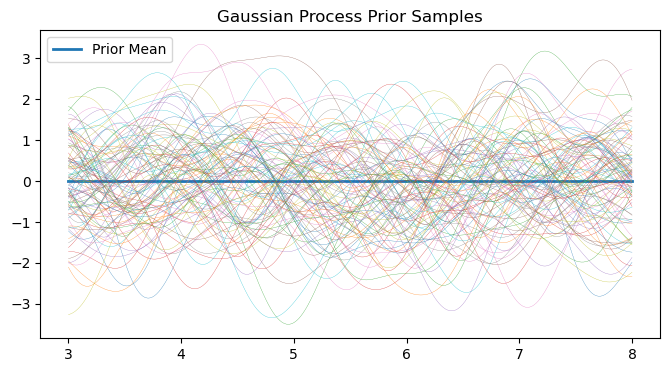

We can see that samples of the distribution of functions averages to the described mean function (here, = 0) with a constant variance (variance is not plotted here) over the entire search space. These functions are called the priors. 

After conditioning, we can see the conditioned priors go through exactly the points of the training data (noise is not considered here). The average of these functions give the mean and provides the associated variance. The functions are called the posteriors.

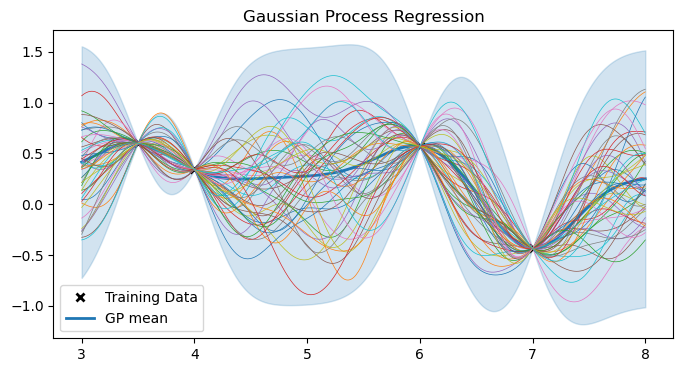

We have seen previously that the acquisition function considered the mean and associated variance to obtain a single recommendation. Thompson Sampling allows us to obtain batch recommendations by considering individual posterior functions obtained from the distribution instead of the mean and variance directly. The number of recommendations (batch number) determines the number of sampled posteriors we require to obtain. 

To obtain the posteriors, we need to obtain the mean and full covariance matrix of all points of the interested search space as each point in this space will have to be conditioned on every other point in this space. A function for doing so is created and seen below. It takes in an object of the GP_model_zeromean class and the interested search space as inputs and gives the mean and covariance matrix as output. 

We can then draw posteriors using the `np.random.multivariate_normal()` function. 

``` python
def GP_predict_full(gp, Xtest):
    """
    Returns (mean_vector, cov_matrix) at the inputs Xstar_norm.
    """
    Xstar_norm = (Xtest - gp.X_mean) / gp.X_std
    # unpack
    ell, sf2 = np.exp(2*gp.hyperparam_optimized[:gp.nx_dimensions, 0]), \
                np.exp(2*gp.hyperparam_optimized[gp.nx_dimensions, 0])
    sn2 = np.exp(2*gp.hyperparam_optimized[gp.nx_dimensions+1, 0]) + 1e-8
    
    # training data
    Xn, Yn = gp.X_norm, gp.Y_norm[:,0]         # here we only have one output
    K = gp.Cov_mat(gp.kernel, Xn, ell, sf2) + sn2*np.eye(gp.number_of_point)
    K = (K + K.T)*0.5
    Kinv = np.linalg.solve(K, np.eye(K.shape[0]))

    # cross-covariances
    # shape: (n_train, n_test)
    Ks = sf2 * np.exp(-0.5 * cdist(Xn, Xstar_norm, 'seuclidean', V=ell)**2)

    # test-test covariance
    Kss = sf2 * np.exp(-0.5 * cdist(Xstar_norm, Xstar_norm, 'seuclidean', V=ell)**2)

    # predictive mean and covariance
    mu_star = Ks.T.dot(Kinv).dot(Yn)
    cov_star = Kss - Ks.T.dot(Kinv).dot(Ks)
    # ensure symmetry
    cov_star = (cov_star + cov_star.T)*0.5

    #unnormalise the mean and covariance matrix
    mu_plot = mu_star*gp.Y_std + gp.Y_mean
    cov_plot = cov_star * (gp.Y_std**2)
    return  mu_plot, cov_plot

mu_plot, cov_plot = GP_predict_full(GP_m, X_searchspace.reshape(-1,1))
samples = np.random.multivariate_normal(mu_plot.flatten(), cov_plot, size=50) #drawing 50 posterior samples
plt.plot(X_searchspace.reshape(-1,1), samples[1], lw=0.5) #we can plot the posteriors, here the first of 50 posterior is plotted

```

Using this function, can you recreate the posterior plot as seen above? (We are not performing BO here, just GP regression, inference and obtaining posteriors.)

```python
def obj_func(x):
	return np.sin(x**np.sin(x))

# training data
X_training = np.array([3.5, 4, 6, 7])
ndata      = X_training.shape[0]
X_training = X_training.reshape(ndata,1)
Y_training = obj_func(X_training )

# search space
number_points_searchspace  = 500
X_searchspace              = np.linspace(3, 8.0, num=number_points_searchspace)

Ysearchspace_mean        = np.zeros(number_points_searchspace)
Ysearchspace_std         = np.zeros(number_points_searchspace)

GP_m = GP_model_meanzero(X_training, Y_training, 'SquaredExponential', hyperparams_multistart_loops = 3)

for number in range(len(X_searchspace)):
    m_ii, std_ii   = GP_m.GP_inference_np(X_searchspace[number])
    Ysearchspace_mean[number] = m_ii.item()
    Ysearchspace_std[number]  = std_ii.item()


ax = plt.figure(figsize = (8,4), dpi = 100)
plt.plot(X_training, Y_training  , 'kx', mew=2)
plt.plot(X_searchspace,Ysearchspace_mean, 'C0', lw=2)
plt.gca().fill_between(X_searchspace.flat, 
                       Ysearchspace_mean  - 3*np.sqrt(Ysearchspace_std), 
                       Ysearchspace_mean  + 3*np.sqrt(Ysearchspace_std), 
                       color='C0', alpha=0.2)

##### 
#Obtain full mean and covariance matrix of interested search space, obtain posteriors and plot
#Write your code here!
#####

plt.title('Gaussian Process Regression')
plt.legend(('Training Data', 'Objective Function', 'GP mean', 'GP Confidence Interval'),
           loc='lower right')
plt.show()
```

In [4]:
# You can use your own GP class or use the class below
# If using your own GP class - remember to modify the ...
# 'GP_m = GP_model_meanzero(X_training, Y_training, 'SquaredExponential', hyperparams_multistart_loops = 3)'
# ... section of the above code! (And do any other troubleshooting - hence would recommend using the code below for ease')

class GP_model_meanzero:

    def __init__(self, X, Y, kernel, hyperparams_multistart_loops):
        self.X, self.Y, self.kernel = X, Y, kernel
        self.number_of_point, self.nx_dimensions, self.ny_dimensions = X.shape[0], X.shape[1], Y.shape[1]
        self.multistart_loops            = hyperparams_multistart_loops

        #Normalisation
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        #Determine Kernel Hyperparameters 
        self.hyperparam_optimized , self.inverse_covariance_matrix_opt   = self.determine_hyperparameters()     
        
    def Cov_mat(self, kernel, X_norm, W, sf2):
        if kernel == 'SquaredExponential':
            xixj_euclidean_distance = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*xixj_euclidean_distance)
            return (cov_matrix)
        else:
            print('ERROR no kernel with name ', kernel)


    def negative_loglikelihood(self, hyper, X, Y):
        # internal parameters
        n_point, nx_dim = self.number_of_point, self.nx_dimensions
        kernel          = self.kernel
         
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        # obtaining negative logliklihood via Cholesky decomposition 
        K       = self.Cov_mat(kernel, X, W, sf2)  
        K       = K + (sn2 + 1e-8)*np.eye(n_point) 
        K       = (K + K.T)*0.5                   
        L       = np.linalg.cholesky(K)            
        logdetK = 2 * np.sum(np.log(np.diag(L)))   
        invLY   = np.linalg.solve(L,Y)             
        alpha   = np.linalg.solve(L.T,invLY)       
        NLL     = np.dot(Y.T,alpha) + logdetK     
        return (NLL)

    
    def determine_hyperparameters(self): 
        # setting up bounds for the log likelyhood minimsation
        lower_bound = np.array([-4.]*(self.nx_dimensions+1) + [-8.])  # lengthscales + signal variance, noise variance
        upper_bound = np.array([4.]*(self.nx_dimensions+1) + [ -2.]) 
        bounds      = np.hstack((lower_bound.reshape(self.nx_dimensions+2,1), upper_bound.reshape(self.nx_dimensions+2,1)))

        #gives number of input set of random starting guesses for each hyperparameter
        multi_startvec         = sobol_seq.i4_sobol_generate(self.nx_dimensions + 2, self.multistart_loops)
        
        #variables for storing information during loop
        temp_min_hyperparams   = [0.]*self.multistart_loops
        temp_loglikelihood     = np.zeros((self.multistart_loops))
        hyperparam_optimized   = np.zeros((self.nx_dimensions+2, self.ny_dimensions)) #for best solutions
        inverse_covariance_matrix_opt = []
        
        #minimisation of hyperparameters
        for i in range(self.ny_dimensions):
            for j in range(self.multistart_loops ):
                #initilising hyperparam guess
                hyperparams_initialisation   = lower_bound + (upper_bound-lower_bound)*multi_startvec[j,:] # mapping sobol unit cube to boudns
               
                result = minimize(self.negative_loglikelihood,
                               hyperparams_initialisation,
                               args=(self.X_norm, self.Y_norm[:,i]),
                               method='SLSQP',
                               options={'disp':False,'maxiter':10000},
                               bounds=bounds,
                               tol=1e-12)
                
                temp_min_hyperparams[j] = result.x
                temp_loglikelihood[j]   = result.fun  

            # choosing best solution from temporary lists
            minimumloglikelihood_index    = np.argmin(temp_loglikelihood)
            hyperparam_optimized[:,i]     = temp_min_hyperparams[minimumloglikelihood_index  ]
    
            # exponential to recover value from log space
            lengthscale_opt         = np.exp(2.*hyperparam_optimized[:self.nx_dimensions,i])
            signalvarience_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions,i])
            noise_opt               = np.exp(2.*hyperparam_optimized[self.nx_dimensions+1,i]) + 1e-8
    
            #obtain convarience matrix from optimised kernel hyper parameters
            covarience_matrix_opt              = self.Cov_mat(self.kernel, self.X_norm, lengthscale_opt,signalvarience_opt) + noise_opt*np.eye(self.number_of_point)
            self.covarience_matrix_opt         = covarience_matrix_opt
            inverse_covariance_matrix_opt     += [np.linalg.solve(covarience_matrix_opt, np.eye(self.number_of_point))]
            
        return (hyperparam_optimized , inverse_covariance_matrix_opt)

    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        # internal parameters
        nx_dim = self.nx_dimensions

        #covariance of sample
        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)
        return (cov_matrix )         


    def GP_inference_np(self, x):
        nx_dim                   = self.nx_dimensions
        kernel, ny_dim           = self.kernel, self.ny_dimensions
        hypopt, Cov_mat          = self.hyperparam_optimized, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.inverse_covariance_matrix_opt
        Xsample, Ysample         = self.X_norm, self.Y_norm

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        
        # ny_dim -> number of outputs
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # calculation of covaraince for each output
            # although noise hyperparameter determiend, it is ignored here for better visualisation
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) 

        # un-normalisation (obtianing actual mean and variance) 
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        return (mean_sample, var_sample)

#### Excersise A1_4: 
##### Concepts: Thompson Sampling, Batch BO

Now that we can draw samples of the posterior, we can now adapt the `BO_1D` class below to allow for batch BO!

Similar to the LCB acquisition function, we can draw recommendations from taking the minima (to perform minimisation) from each of the sampled posteriors. Can you modify the `BO_1D` class with the following to allow for batch BO?

1. Add a new 'batch' input to specify the number of recommendations per iteration
2. Create a new 'ThompsonSamnpling' acquisition function which draws the number of posterior sample specified by the 'batch_number' and obtain the input that correspond with the posterior minimum. `np.argmin()` function can be useful. It returns the index of the minimum number form a list.
3. Modify the `plt.plot(range(iterations), self.exploredY)` function to a scatter plot to observe the batch evaluations over the iterations.

```python
class BO_1D: 
    def __init__(self, X, kernel, X_searchspace,  iterations, acquisition_function, objective_func, print_graph, acquisition_hyperparam):       
        
        self.X = X

        Fx_training              = np.array([objective_func(x) for x in self.X])
        self.Y                   = Fx_training.reshape(Fx_training.shape[0],1)
        
        fx_searchspace           = np.array([objective_func(x) for x in X_searchspace])
        Ysearchspace_mean        = np.zeros(number_points_searchspace**(np.shape(X_training)[1]))
        Ysearchspace_std         = np.zeros(number_points_searchspace**(np.shape(X_training)[1]))
        
        self.minY = []
        self.exploredY = []
        
        for i in range(iterations):
            GP_m = GP.GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops = 3)
            
            for number in range(len(X_searchspace)):
                m_ii, std_ii   = GP_m.GP_inference_np(X_searchspace[number])
                Ysearchspace_mean[number] = m_ii.item()
                Ysearchspace_std[number]  = std_ii.item()
            
            if acquisition_function == 'Thompson':
               ... # Add thompson sampling code here!
                
            else: 
                print('No acquisition function called ', acquisition_function)
                break
            
            self.X = np.append(self.X, [[X_acquisitionfunc]],0)
            self.Y = np.append(self.Y, [[objective_func(X_acquisitionfunc)]],0)

            self.minY += [min(self.Y)]
            self.exploredY += [objective_func(X_acquisitionfunc)]

            if print_graph == True: 
                pass
            else: 
                pass
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.exploredY)
        plt.show()

```

#### Excersise A1_5: 
##### Concepts: Thompson Sampling, Batch BO

A code for the same implimentation of batch BO with thompson sampling is given below. We will run BO in 2 and 3 dimensions with the inputs specified below. Observe how much time it will take for only 2 rounds of BO with only 20 points for each input dimensions! Why does it take so much longer when going to higher dimension? 

*warning: 3 dimension computation could take a few minutes 

``` python
class BO_multiD_batch: 
    def __init__(self, X, kernel, X_searchspace, iterations,acquisition_function, objective_func,print_graph, acquisition_hyperparam, batch):

        # 1) initilisation
        self.X = np.array(X)
        # 2) build Y as an (n×1) vector
        Fx_training = np.array([objective_func(x) for x in self.X])
        self.Y = Fx_training.reshape(-1, 1)

        self.minY = []
        self.exploredY = []

        for i in range(iterations):
            # 3) fit GP to the current (X,Y)
            GP_m = GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops=3)

            # 4) predict over the search space
            means = np.zeros(len(X_searchspace))
            vars  = np.zeros(len(X_searchspace))
            for idx, xx in enumerate(X_searchspace):
                m, v = GP_m.GP_inference_np(xx)
                means[idx] = m.item()
                vars[idx]  = v.item()

            # 5) sample from the joint posterior for Thompson sampling
            mu_plot, cov_plot = GP_predict_full(GP_m, X_searchspace)
            samples = np.random.multivariate_normal(mu_plot, cov_plot, size=batch)

            # 6) pick batch points
            new_X = []
            for s in samples:
                choice = np.argmin(s)
                new_X.append(X_searchspace[choice])
            new_X = np.array(new_X)

            # 7) evaluate objective and append to X,Y
            new_Y = np.array([objective_func(x) for x in new_X]).reshape(-1, 1)
            self.X = np.vstack([self.X, new_X])
            self.Y = np.vstack([self.Y, new_Y])

            self.minY     += [self.Y.min()]
            self.exploredY += [new_Y.flatten().tolist()]

            if print_graph:
                print(f"Iteration {i} complete.")

        # 8) finally, plot
        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()

        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        for i, vals in enumerate(self.exploredY):
            plt.scatter([i]*batch, vals)
        plt.show()
```

2 dimension input: 

``` python
x1loc  = [-4,  -1,  2]; x2loc = [-3, -2, 7]
Xtrain = [[x,y] for x in x1loc for y in x2loc]
X_training = np.array(Xtrain)

number_points_pervariable      = 20
number_points_searchspace   = number_points_pervariable ** (np.shape(X_training)[1])

#Here, the interested search space is symmetrical, if it is non symmetrical, one can define each dimension individually and build the search space recursively
X_searchspace     = np.linspace(-5, 8, num=number_points_pervariable)
X_searchspace     = np.array([[x,y] for x in X_searchspace for y in X_searchspace])

def obj_func(X):
	return (np.sin(X[0])+np.sin(X[1]))

BO_m = BO_multiD_batch(X = X_training,  
   kernel = 'SquaredExponential', 
   X_searchspace = X_searchspace, 
   iterations = 2, 
   acquisition_function = 'Thompson', 
   objective_func = obj_func, 
   print_graph = True, 
   acquisition_hyperparam=[10], 
    batch = 5)

```

3 dimension input: 

``` python
x1loc  = [-4,  -1]; x2loc = [-3, -2]; x3loc = [-3, 1]
Xtrain = [[x,y,a] for x in x1loc for y in x2loc for a in x3loc]
X_training = np.array(Xtrain)

number_points_pervariable    = 20
number_points_searchspace   = number_points_pervariable ** (np.shape(X_training)[1])

#Here, the interested search space is symmetrical, if it is non symmetrical, one can define each dimension individually and build the search space recursively
X_searchspace     = np.linspace(-5, 8, num=number_points_pervariable)
X_searchspace     = np.array([[x,y,a] for x in X_searchspace for y in X_searchspace for a in X_searchspace])

def obj_func(X):
	return (np.sin(X[0])+np.sin(X[1])+np.cos(X[2]))

BO_m = BO_multiD_batch(X = X_training,  
   kernel = 'SquaredExponential', 
   X_searchspace = X_searchspace, 
   iterations = 2, 
   acquisition_function = 'Thompson', 
   objective_func = obj_func, 
   print_graph = True, 
   acquisition_hyperparam=[10], 
    batch = 5)
```

#### Excersise A1_6: 
##### Concepts: Marginal Thompson Sampling, Batch BO

We can attibute the long run times to the need for the full covariance matrix to be evaluated in `GP_predict_full()`. Another method to obtain batach recommendations is through a tecnique called 'Marginal Thompson Sampling'. Here, we are not obtaining posterior samples. Instead, we can draw individual samples of each point with the mean and standard deviation of each point (no covariance required) with the standard deviation scaled by a hyperparameter (similar to LCB) and a scalar drawn from the standard normal distribution via `np.random.randn()`. We can observe and example of 5 batch samples and recommendations in the following plot.

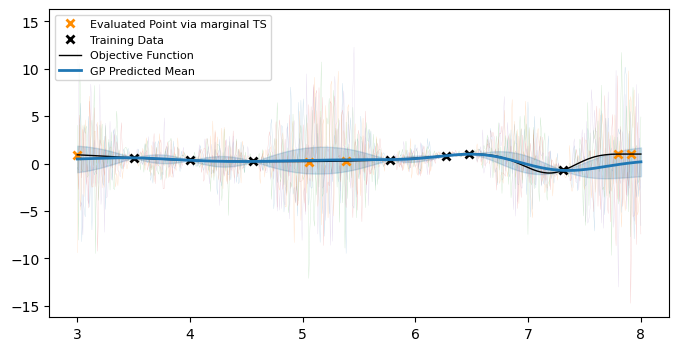

An implimentation to obtain Marginal TS samples is given below. Similar to excersise A1_4, can you modify your previous `BO_1D_batch` function to perform batch BO via marginal TS? (You do not have to use the given code if it does not fit with your previous implimentation.)

``` python

for number in range(batch): 
    if acquisition_function == 'ThompsonMarginal':
        ts_sample  = Ysearchspace_mean + acquisition_hyperparam[0]*np.sqrt(Ysearchspace_std)*np.random.randn(X_searchspace.shape[0])
        new_X.append(X_searchspace[np.argmin(ts_sample)])
        plt.plot(X_searchspace,ts_sample, lw = 0.2, alpha = 0.3)
    else: 
        print('No acquisition function called ', acquisition_function)
        break

```


Use the following code to test your batch BO code. 

``` python
def obj_func(x):
	return np.sin(x**np.sin(x))

# training data
X_training = np.array([3.5, 4])
ndata      = X_training.shape[0]
X_training = X_training.reshape(ndata,1)

# search space
number_points_searchspace  = 500
X_searchspace              = np.linspace(3, 8.0, num=number_points_searchspace)

BO_m = BO_1D_batch(X = X_training,  
   kernel = 'SquaredExponential', 
   X_searchspace = X_searchspace, 
   iterations = 25, 
   acquisition_function = 'ThompsonMarginal', 
   objective_func = obj_func, 
   print_graph = True, 
   acquisition_hyperparam=[3], 
   batch = 5)
```

#### Excersise A1_7: 
##### Concepts: Marginal Thompson Sampling, Batch BO

Similar to excersise A1_5, some code for the multidimensional batch BO is given below. Use this code and explore how one could perform multidimensional BO (go up to 5/6 dimensions with your chosen objective function! See how the various parts of the inputs (hyperparameters etc.) and code perform with varying values! How long does the code take to run!). An example with a 2D input is shown.

```python
class BO_multiD_batch: 
    def __init__(self, X, kernel, X_searchspace, iterations,acquisition_function, objective_func,print_graph, acquisition_hyperparam, batch):

        # 1) initilisation
        self.X = np.array(X)
        # 2) build Y as an (n×1) vector
        Fx_training = np.array([objective_func(x) for x in self.X])
        self.Y = Fx_training.reshape(-1, 1)

        self.minY = []
        self.exploredY = []

        for i in range(iterations):
            # 3) fit GP to the current (X,Y)
            GP_m = GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops=3)

            # 4) predict over the search space
            means = np.zeros(len(X_searchspace))
            varience  = np.zeros(len(X_searchspace))
            for idx, xx in enumerate(X_searchspace):
                m, v = GP_m.GP_inference_np(xx)
                means[idx] = m.item()
                varience[idx]  = v.item()

            # 5) sample from the joint posterior for Thompson sampling
            if acquisition_function == 'ThompsonMarginal':
                new_X = []
                for number in range(batch): 
                    ts_sample  = means + acquisition_hyperparam[0]*np.sqrt(varience)*np.random.randn(X_searchspace.shape[0])
                    new_X.append(X_searchspace[np.argmin(ts_sample)])
                new_X = np.array(new_X)
            else: 
                print('No acquisition function named', acquisition_function)
            
            # 7) evaluate objective and append to X,Y
            new_Y = np.array([objective_func(x) for x in new_X]).reshape(-1, 1)
            self.X = np.vstack([self.X, new_X])
            self.Y = np.vstack([self.Y, new_Y])

            self.minY     += [self.Y.min()]
            self.exploredY += [new_Y.flatten().tolist()]

            if print_graph:
                print(f"Iteration {i} complete.")

        # 8) finally, plot
        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()

        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        for i, vals in enumerate(self.exploredY):
            plt.scatter([i]*batch, vals)
        plt.show()

```

For 2D input: 

``` python
x1loc  = [-4,  -1,  2]; x2loc = [-3, -2, 7]
Xtrain = [[x,y] for x in x1loc for y in x2loc]
X_training = np.array(Xtrain)

number_points_pervariable      = 20
number_points_searchspace   = number_points_pervariable ** (np.shape(X_training)[1])

#Here, the interested search space is symmetrical, if it is non symmetrical, one can define each dimension individually and build the search space recursively
X_searchspace     = np.linspace(-5, 8, num=number_points_pervariable)
X_searchspace     = np.array([[x,y] for x in X_searchspace for y in X_searchspace])

def obj_func(X):
	return (np.sin(X[0])+np.sin(X[1]))

BO_m = BO_multiD_batch(X = X_training,  
   kernel = 'SquaredExponential', 
   X_searchspace = X_searchspace, 
   iterations = 20, 
   acquisition_function = 'ThompsonMarginal', 
   objective_func = obj_func, 
   print_graph = True, 
   acquisition_hyperparam=[10], 
   batch = 5)
```

